In [1]:

# Add PATH
push!(LOAD_PATH, joinpath(@__DIR__, "..", "src"))

#using PyPlot
using Plots
using BenchmarkTools
using DifferentialEquations

using LSM.PhysCon
using LSM.WaterVaporMod
using LSM.LeafPhotosynthesisMod

output_dir = joinpath(@__DIR__,"..","output")
mkpath(output_dir)

"/Users/gentine/Dropbox/Collaborations_Projects/Optimal_Stomata/LSM-SPAM/test/../output"

In [7]:

# function lorenz!(du,u,p,t)
#  du[1] = 10.0*(u[2]-u[1]);
#  du[2] = u[1]*(28.0-u[3]) - u[2];
#  du[3] = u[1]*u[2] - (8/3)*u[3];
# end
# u0 = [1.0;0.0;0.0];
# tspan = (0.0,100.0);
# prob = ODEProblem(lorenz!,u0,tspan);
# sol = solve(prob);

# plot(sol,vars=(1,2,3))

# Create a leaf structure
l = leaf_params{Float32}();
# Create a Flux structure
f = LeafPhotosynthesisMod.fluxes{Float32}();
# Create a meteo structure
met = meteo{Float32}();
#met = meteo();

# initialize some reasonable values
f.je   = 100; f.gbc  = 100; f.gbv  = 100; f.ceair= 1500; f.eair = 1500; f.APAR = 500; # leaf should not have eair
l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=40e-3; l.c_leaf=50/100*4184;l.ra=50;l.psi_l=-1e6;l.psi_l50 = -2e6;l.ck=3;


In [8]:

# A diurnal cycle for radiation and Tair
Deltat  = 60;
Samp    = 500; # W/m2 amplitude
Tmean   = 273.15+22;
DeltaT  = 3;
omega   = 2*π/(24*3600);
t       = range(0, stop=24*3600, step=Deltat); # diurnal cycle in seconds
#print(t)
phi_t   = omega*t-π*ones(size(t))/2;
Sdown_t = zeros(size(t));
Tair_t  = zeros(size(t));
zeros_t = zeros(size(t));
for i = 1:length(Sdown_t)
    Sdown_t[i] = Samp*max( sin(phi_t[i]),zeros_t[i] );#max(sin(phase[i]),zeros(size(t[i])));
    Tair_t[i]  = Tmean + DeltaT*sin(phi_t[i]-π/3);
end
#print(typeof(phase[1]));
#print(typeof(Sdown_t[1]));
#print(Sdown_t);
#clf();
#fig = figure("Diurnal cycle", figsize=(10,5));
# plot(t/3600,Sdown_t)
#plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))))
#    title = "Shortwave Incoming radiation (W/m^2)");#,
#    xlabel = "Hours",
#    ylabel = "S_{down} (W/m^2)")
#plot(t/3600,Tair_t-273.15*ones(size(Tair_t)),
#    title = "Temperature (C)",
#    xlabel = "Hours",
#    ylabel = "Temperature (C)")


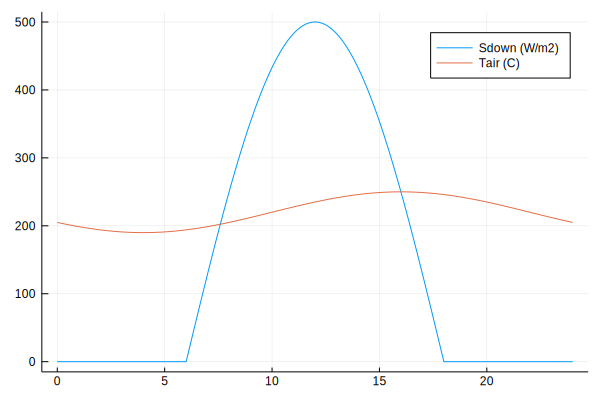

In [9]:
plot(t/3600,Sdown_t,label="Sdown (W/m2)")
plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))),label="Tair (C)")

In [10]:
psi_s      = -0.3e6 ; # soil water potential (Pa)
U          =  1.0;
RH         =  65/100;
eps_air    =  0.75;
tspan      =  (0.0,Deltat);
N          =  length(Sdown_t);
mutable struct parameters_ode
    l::leaf_params;
    met::meteo;
    psi_s;
end


In [11]:
# small time stepping
dt = 0.1*60; # in s
T_t    = zeros(size(Sdown_t));
psil_t = zeros(size(Sdown_t));
Rn_t   = zeros(size(Sdown_t));
H_t    = zeros(size(Sdown_t));
LE_t   = zeros(size(Sdown_t));
dummy  = zeros(5,1);
met.zscreen  = 20.0 + 2.0;

function f_ode!(du,u,p,t,dummy) # p are parameters
    dummy .= LeafEnergyWaterBalance(u[1], u[2], p.met, p.l,  p.psi_s);
    du    .= dummy[1:2];
    #println("du_inside = $(du), u_inside = $(u)")
end

let
    for i=1:N
        met.S_down = Sdown_t[i];
        met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
        met.T_air  = Tair_t[i];
        met.ea_air = RH*SatVap(Tair_t[i])[1];
        met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
        f.APAR     = met.PAR;
        met.U      = U;
        met.Ca     = 400.0; #ppm
        for j=1:trunc(Deltat/dt)
            u    = [l.T;l.psi_l];
            p    = parameters_ode(l,met,psi_s);
            #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
            #prob = ODEProblem(f_ode!,u0,tspan,p);
            du   = zeros(size(u));
            f_ode!(du,u,p,t,dummy);
            #println("du_outside = $(du), u_outside = $(u)")
            (l.T,l.psi_l) = du*dt+u;
            T_t[i]  = l.T; psil_t[i]=l.psi_l;
            Rn_t[i] = dummy[3]; H_t[i] = dummy[4]; LE_t[i] = dummy[5];
        end
    end

#     l.T        = Tair_t[1]; # initialize temperature of the leaf
#     l.psi_l    = psi_s;

#     for i=1:N
#         met.S_down = Sdown_t[i];
#         met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
#         met.T_air  = Tair_t[i];
#         met.ea_air = RH*SatVap(Tair_t[i])[1];
#         u0   = [l.T;l.psi_l];
#         p    = parameters_ode(l,met,psi_s);
#         #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
#         prob = ODEProblem(f_ode!,u0,tspan,p);
#         sol  = solve(prob);
#         (l.T,l.psi_l) = sol[:,end];
#         T_t[i] = l.T; psil_t[i]=l.psi_l;
#         #print((l.T,l.psi_l) )
#         #dT_dt,dH2Ol_dt = LeafEnergyWaterBalance(met, l, psi_s);
#         #l.T        = l.T + Deltat*dT_dt;
#     end

   
end


Rn=-122.882965W/m2, SEB=-230.3262021026328W/m2, H= 107.32306W /m2, LE= 0.12017793271093166W /m2, dT_dt=-5286.552 (K/hr), gs=0.01,ra=50.0
Rn=-73.23547W/m2, SEB=29.456819141184596W/m2, H= -102.813416W /m2, LE= 0.12112275334665328W /m2, dT_dt=-3150.6655 (K/hr), gs=0.01,ra=50.0
Rn=-45.724884W/m2, SEB=182.20324703871233W/m2, H= -228.04985W /m2, LE= 0.1217193919517287W /m2, dT_dt=-1967.1317 (K/hr), gs=0.01,ra=50.0
Rn=-29.304352W/m2, SEB=276.8157301368539W/m2, H= -306.2422W /m2, LE= 0.12210555650546406W /m2, dT_dt=-1260.7035 (K/hr), gs=0.01,ra=50.0
Rn=-19.078827W/m2, SEB=337.15290974287024W/m2, H= -356.3541W /m2, LE= 0.12235881181728447W /m2, dT_dt=-820.79083 (K/hr), gs=0.01,ra=50.0
Rn=-12.544495W/m2, SEB=376.3128375801963W/m2, H= -388.97986W /m2, LE= 0.1225261893349429W /m2, dT_dt=-539.67706 (K/hr), gs=0.01,ra=50.0
Rn=-8.300415W/m2, SEB=402.00889342621815W/m2, H= -410.43195W /m2, LE= 0.12263733550060382W /m2, dT_dt=-357.09244 (K/hr), gs=0.01,ra=50.0
Rn=-5.514923W/m2, SEB=418.98846417749087W/

Rn=-0.009887695W/m2, SEB=452.81880898789694W/m2, H= -452.9516W /m2, LE= 0.12290243788431164W /m2, dT_dt=-0.42537886 (K/hr), gs=0.01,ra=50.0
Rn=-0.006652832W/m2, SEB=452.8387673954604W/m2, H= -452.96832W /m2, LE= 0.12290252641457004W /m2, dT_dt=-0.2862117 (K/hr), gs=0.01,ra=50.0
Rn=-0.004425049W/m2, SEB=452.8526833494988W/m2, H= -452.98W /m2, LE= 0.12290258800116012W /m2, dT_dt=-0.19037016 (K/hr), gs=0.01,ra=50.0
Rn=-0.0030212402W/m2, SEB=452.86135030319457W/m2, H= -452.98727W /m2, LE= 0.12290262649291364W /m2, dT_dt=-0.12997687 (K/hr), gs=0.01,ra=50.0
Rn=-0.0020141602W/m2, SEB=452.86742327429715W/m2, H= -452.99234W /m2, LE= 0.12290265343720276W /m2, dT_dt=-0.08665125 (K/hr), gs=0.01,ra=50.0
Rn=-0.0013122559W/m2, SEB=452.8717872687231W/m2, H= -452.996W /m2, LE= 0.1229026726831547W /m2, dT_dt=-0.0564546 (K/hr), gs=0.01,ra=50.0
Rn=-0.04876709W/m2, SEB=452.5786002434133W/m2, H= -452.75027W /m2, LE= 0.12290732494609675W /m2, dT_dt=-2.0980105 (K/hr), gs=0.01,ra=50.0
Rn=-0.03262329W/m2, SEB=4

Rn=-0.021331787W/m2, SEB=452.7479742982878W/m2, H= -452.89227W /m2, LE= 0.12296686382162164W /m2, dT_dt=-0.9177155 (K/hr), gs=0.01,ra=50.0
Rn=-0.014282227W/m2, SEB=452.7914311368134W/m2, H= -452.92868W /m2, LE= 0.12296705654598443W /m2, dT_dt=-0.61443615 (K/hr), gs=0.01,ra=50.0
Rn=-0.009552002W/m2, SEB=452.8209109862281W/m2, H= -452.95343W /m2, LE= 0.12296718760003389W /m2, dT_dt=-0.41093698 (K/hr), gs=0.01,ra=50.0
Rn=-0.006439209W/m2, SEB=452.84004542291217W/m2, H= -452.96945W /m2, LE= 0.1229672724003526W /m2, dT_dt=-0.27702144 (K/hr), gs=0.01,ra=50.0
Rn=-0.004333496W/m2, SEB=452.85307637095286W/m2, H= -452.98038W /m2, LE= 0.12296733021903992W /m2, dT_dt=-0.18643148 (K/hr), gs=0.01,ra=50.0
Rn=-0.0029296875W/m2, SEB=452.8617738421725W/m2, H= -452.98767W /m2, LE= 0.12296736876496124W /m2, dT_dt=-0.12603818 (K/hr), gs=0.01,ra=50.0
Rn=-0.0019836426W/m2, SEB=452.86781629565905W/m2, H= -452.99277W /m2, LE= 0.12296739574716793W /m2, dT_dt=-0.08533835 (K/hr), gs=0.01,ra=50.0
Rn=-0.0012512207W

Rn=-0.04537964W/m2, SEB=452.5986396331212W/m2, H= -452.76706W /m2, LE= 0.12304005437879714W /m2, dT_dt=-1.952279 (K/hr), gs=0.01,ra=50.0
Rn=-0.030395508W/m2, SEB=452.691595763014W/m2, H= -452.84503W /m2, LE= 0.12304046745474496W /m2, dT_dt=-1.3076462 (K/hr), gs=0.01,ra=50.0
Rn=-0.020477295W/m2, SEB=452.75327151430093W/m2, H= -452.8968W /m2, LE= 0.12304074155844456W /m2, dT_dt=-0.8809544 (K/hr), gs=0.01,ra=50.0
Rn=-0.013763428W/m2, SEB=452.7949583407072W/m2, H= -452.93176W /m2, LE= 0.12304092687095988W /m2, dT_dt=-0.5921169 (K/hr), gs=0.01,ra=50.0
Rn=-0.009246826W/m2, SEB=452.82279024841415W/m2, H= -452.95508W /m2, LE= 0.12304105041396877W /m2, dT_dt=-0.39780802 (K/hr), gs=0.01,ra=50.0
Rn=-0.0061950684W/m2, SEB=452.8418636498058W/m2, H= -452.9711W /m2, LE= 0.12304113535040555W /m2, dT_dt=-0.26651824 (K/hr), gs=0.01,ra=50.0
Rn=-0.0040893555W/m2, SEB=452.85489459775374W/m2, H= -452.98203W /m2, LE= 0.12304119326190119W /m2, dT_dt=-0.1759283 (K/hr), gs=0.01,ra=50.0
Rn=-0.0026855469W/m2, SEB

Rn=-0.001373291W/m2, SEB=452.8712853550726W/m2, H= -452.99573W /m2, LE= 0.12306889297427645W /m2, dT_dt=-0.059080396 (K/hr), gs=0.01,ra=50.0
Rn=-0.044525146W/m2, SEB=452.6040081459525W/m2, H= -452.7716W /m2, LE= 0.12307315287564044W /m2, dT_dt=-1.9155178 (K/hr), gs=0.01,ra=50.0
Rn=-0.029815674W/m2, SEB=452.6952247813217W/m2, H= -452.8481W /m2, LE= 0.12307355852204686W /m2, dT_dt=-1.2827011 (K/hr), gs=0.01,ra=50.0
Rn=-0.020019531W/m2, SEB=452.7560460440875W/m2, H= -452.89914W /m2, LE= 0.12307382895936415W /m2, dT_dt=-0.8612609 (K/hr), gs=0.01,ra=50.0
Rn=-0.013458252W/m2, SEB=452.79687838203654W/m2, H= -452.9334W /m2, LE= 0.12307401054156965W /m2, dT_dt=-0.5789879 (K/hr), gs=0.01,ra=50.0
Rn=-0.00894165W/m2, SEB=452.8247102896548W/m2, H= -452.95673W /m2, LE= 0.12307413417332405W /m2, dT_dt=-0.38467905 (K/hr), gs=0.01,ra=50.0
Rn=-0.006011963W/m2, SEB=452.8429597202396W/m2, H= -452.97205W /m2, LE= 0.12307421530724255W /m2, dT_dt=-0.25864086 (K/hr), gs=0.01,ra=50.0
Rn=-0.004058838W/m2, SEB=4

Rn=-0.013031006W/m2, SEB=452.79909895919025W/m2, H= -452.93524W /m2, LE= 0.12311173416912448W /m2, dT_dt=-0.5606073 (K/hr), gs=0.01,ra=50.0
Rn=-0.008666992W/m2, SEB=452.8260458608083W/m2, H= -452.95782W /m2, LE= 0.12311185403546519W /m2, dT_dt=-0.37286296 (K/hr), gs=0.01,ra=50.0
Rn=-0.0058898926W/m2, SEB=452.84341028542775W/m2, H= -452.9724W /m2, LE= 0.12311193136912005W /m2, dT_dt=-0.25338927 (K/hr), gs=0.01,ra=50.0
Rn=-0.0039367676W/m2, SEB=452.8555562273877W/m2, H= -452.9826W /m2, LE= 0.12311198550292668W /m2, dT_dt=-0.16936381 (K/hr), gs=0.01,ra=50.0
Rn=-0.0026855469W/m2, SEB=452.8633686925873W/m2, H= -452.98917W /m2, LE= 0.12311202030333886W /m2, dT_dt=-0.115535 (K/hr), gs=0.01,ra=50.0
Rn=-0.0018615723W/m2, SEB=452.8685871752463W/m2, H= -452.99356W /m2, LE= 0.12311204350366059W /m2, dT_dt=-0.08008676 (K/hr), gs=0.01,ra=50.0
Rn=-0.0012817383W/m2, SEB=452.8720661636857W/m2, H= -452.99646W /m2, LE= 0.12311205897056257W /m2, dT_dt=-0.055141706 (K/hr), gs=0.01,ra=50.0
Rn=-0.043121338W/

Rn=-0.0018310547W/m2, SEB=452.8687082096762W/m2, H= -452.99368W /m2, LE= 0.12314359696445469W /m2, dT_dt=-0.07877386 (K/hr), gs=0.01,ra=50.0
Rn=-0.0012512207W/m2, SEB=452.87221771568306W/m2, H= -452.9966W /m2, LE= 0.1231436124419438W /m2, dT_dt=-0.053828806 (K/hr), gs=0.01,ra=50.0
Rn=-0.04208374W/m2, SEB=452.6180632614879W/m2, H= -452.7833W /m2, LE= 0.12314767601207345W /m2, dT_dt=-1.8104858 (K/hr), gs=0.01,ra=50.0
Rn=-0.028259277W/m2, SEB=452.70406141355807W/m2, H= -452.85547W /m2, LE= 0.12314805909816587W /m2, dT_dt=-1.2157433 (K/hr), gs=0.01,ra=50.0
Rn=-0.019042969W/m2, SEB=452.76140368745854W/m2, H= -452.9036W /m2, LE= 0.12314831449457794W /m2, dT_dt=-0.81924814 (K/hr), gs=0.01,ra=50.0
Rn=-0.012756348W/m2, SEB=452.80049653090015W/m2, H= -452.9364W /m2, LE= 0.12314848863110242W /m2, dT_dt=-0.5487912 (K/hr), gs=0.01,ra=50.0
Rn=-0.008544922W/m2, SEB=452.82658894410486W/m2, H= -452.95828W /m2, LE= 0.1231486047232931W /m2, dT_dt=-0.36761135 (K/hr), gs=0.01,ra=50.0
Rn=-0.0057678223W/m2, 

Rn=-0.027404785W/m2, SEB=452.7096103723152W/m2, H= -452.8602W /m2, LE= 0.12318381713796443W /m2, dT_dt=-1.1789821 (K/hr), gs=0.01,ra=50.0
Rn=-0.018432617W/m2, SEB=452.76524366938764W/m2, H= -452.90686W /m2, LE= 0.12318406498736892W /m2, dT_dt=-0.7929902 (K/hr), gs=0.01,ra=50.0
Rn=-0.012420654W/m2, SEB=452.8026275360645W/m2, H= -452.93823W /m2, LE= 0.12318423151359158W /m2, dT_dt=-0.5343494 (K/hr), gs=0.01,ra=50.0
Rn=-0.008392334W/m2, SEB=452.82780442570817W/m2, H= -452.95938W /m2, LE= 0.12318434382306526W /m2, dT_dt=-0.36104685 (K/hr), gs=0.01,ra=50.0
Rn=-0.005584717W/m2, SEB=452.84522988536224W/m2, H= -452.974W /m2, LE= 0.12318442127838675W /m2, dT_dt=-0.24026029 (K/hr), gs=0.01,ra=50.0
Rn=-0.0037841797W/m2, SEB=452.856460303766W/m2, H= -452.98343W /m2, LE= 0.12318447162456989W /m2, dT_dt=-0.16279933 (K/hr), gs=0.01,ra=50.0
Rn=-0.002532959W/m2, SEB=452.8642727689109W/m2, H= -452.99W /m2, LE= 0.12318450647972322W /m2, dT_dt=-0.10897051 (K/hr), gs=0.01,ra=50.0
Rn=-0.0016784668W/m2, SEB=

Rn=-0.039733887W/m2, SEB=452.63240194986423W/m2, H= -452.79535W /m2, LE= 0.12321328451074282W /m2, dT_dt=-1.7093929 (K/hr), gs=0.01,ra=50.0
Rn=-0.026733398W/m2, SEB=452.7132426539357W/m2, H= -452.8632W /m2, LE= 0.12321364489243737W /m2, dT_dt=-1.1500984 (K/hr), gs=0.01,ra=50.0
Rn=-0.017944336W/m2, SEB=452.7680214625354W/m2, H= -452.90918W /m2, LE= 0.12321388902711182W /m2, dT_dt=-0.77198386 (K/hr), gs=0.01,ra=50.0
Rn=-0.012084961W/m2, SEB=452.80452032321415W/m2, H= -452.93982W /m2, LE= 0.12321405178586765W /m2, dT_dt=-0.5199075 (K/hr), gs=0.01,ra=50.0
Rn=-0.008178711W/m2, SEB=452.8288427244729W/m2, H= -452.96024W /m2, LE= 0.12321416029272986W /m2, dT_dt=-0.3518566 (K/hr), gs=0.01,ra=50.0
Rn=-0.005493164W/m2, SEB=452.8453831781865W/m2, H= -452.9741W /m2, LE= 0.12321423392285334W /m2, dT_dt=-0.23632158 (K/hr), gs=0.01,ra=50.0
Rn=-0.003692627W/m2, SEB=452.8566441141359W/m2, H= -452.98355W /m2, LE= 0.12321428430157645W /m2, dT_dt=-0.15886062 (K/hr), gs=0.01,ra=50.0
Rn=-0.0024108887W/m2, SE

Rn=-0.01159668W/m2, SEB=452.8076603509385W/m2, H= -452.9425W /m2, LE= 0.12324785218652567W /m2, dT_dt=-0.49890116 (K/hr), gs=0.01,ra=50.0
Rn=-0.007843018W/m2, SEB=452.83109774623017W/m2, H= -452.9622W /m2, LE= 0.12324795689483828W /m2, dT_dt=-0.3374147 (K/hr), gs=0.01,ra=50.0
Rn=-0.005340576W/m2, SEB=452.8467531940023W/m2, H= -452.97534W /m2, LE= 0.12324802670080409W /m2, dT_dt=-0.2297571 (K/hr), gs=0.01,ra=50.0
Rn=-0.0035095215W/m2, SEB=452.85807516507106W/m2, H= -452.98483W /m2, LE= 0.1232480771164348W /m2, dT_dt=-0.15098323 (K/hr), gs=0.01,ra=50.0
Rn=-0.0024108887W/m2, SEB=452.86500262428035W/m2, H= -452.99066W /m2, LE= 0.12324810814152624W /m2, dT_dt=-0.10371892 (K/hr), gs=0.01,ra=50.0
Rn=-0.0015563965W/m2, SEB=452.8702211068709W/m2, H= -452.99503W /m2, LE= 0.12324813141038879W /m2, dT_dt=-0.06695779 (K/hr), gs=0.01,ra=50.0
Rn=-0.0010070801W/m2, SEB=452.8737000952645W/m2, H= -452.99796W /m2, LE= 0.12324814692298479W /m2, dT_dt=-0.043325625 (K/hr), gs=0.01,ra=50.0
Rn=-0.038269043W/m

Rn=-0.0050354004W/m2, SEB=452.8487087409772W/m2, H= -452.97702W /m2, LE= 0.12327612230403816W /m2, dT_dt=-0.21662812 (K/hr), gs=0.01,ra=50.0
Rn=-0.0033569336W/m2, SEB=452.8591457061301W/m2, H= -452.98578W /m2, LE= 0.12327616886988056W /m2, dT_dt=-0.14441875 (K/hr), gs=0.01,ra=50.0
Rn=-0.0022583008W/m2, SEB=452.86607316532053W/m2, H= -452.9916W /m2, LE= 0.12327619991385937W /m2, dT_dt=-0.09715443 (K/hr), gs=0.01,ra=50.0
Rn=-0.0015258789W/m2, SEB=452.870467677168W/m2, H= -452.99527W /m2, LE= 0.12327621931638014W /m2, dT_dt=-0.06564488 (K/hr), gs=0.01,ra=50.0
Rn=-0.0010070801W/m2, SEB=452.87388563039593W/m2, H= -452.99817W /m2, LE= 0.12327623483841561W /m2, dT_dt=-0.043325625 (K/hr), gs=0.01,ra=50.0
Rn=-0.037139893W/m2, SEB=452.6480824712743W/m2, H= -452.8085W /m2, LE= 0.12327983341320703W /m2, dT_dt=-1.5977966 (K/hr), gs=0.01,ra=50.0
Rn=-0.025024414W/m2, SEB=452.72373520982774W/m2, H= -452.87204W /m2, LE= 0.12328017103164322W /m2, dT_dt=-1.0765761 (K/hr), gs=0.01,ra=50.0
Rn=-0.016784668W

Rn=-0.0014648438W/m2, SEB=452.8708937071816W/m2, H= -452.99567W /m2, LE= 0.12330795297465767W /m2, dT_dt=-0.06301909 (K/hr), gs=0.01,ra=50.0
Rn=-0.0010681152W/m2, SEB=452.8734876896727W/m2, H= -452.99786W /m2, LE= 0.1233079646241839W /m2, dT_dt=-0.04595142 (K/hr), gs=0.01,ra=50.0
Rn=-0.035705566W/m2, SEB=452.6566873483735W/m2, H= -452.8157W /m2, LE= 0.12331143092335876W /m2, dT_dt=-1.5360903 (K/hr), gs=0.01,ra=50.0
Rn=-0.024017334W/m2, SEB=452.72965455147045W/m2, H= -452.87698W /m2, LE= 0.12331175712332827W /m2, dT_dt=-1.0332505 (K/hr), gs=0.01,ra=50.0
Rn=-0.016204834W/m2, SEB=452.7783603886872W/m2, H= -452.91788W /m2, LE= 0.12331197459408626W /m2, dT_dt=-0.6971487 (K/hr), gs=0.01,ra=50.0
Rn=-0.010894775W/m2, SEB=452.8114107782252W/m2, H= -452.94562W /m2, LE= 0.12331212216540251W /m2, dT_dt=-0.4687045 (K/hr), gs=0.01,ra=50.0
Rn=-0.007293701W/m2, SEB=452.833993685067W/m2, H= -452.9646W /m2, LE= 0.12331222313612315W /m2, dT_dt=-0.31378254 (K/hr), gs=0.01,ra=50.0
Rn=-0.0049438477W/m2, SEB

Rn=-0.010192871W/m2, SEB=452.8160285843496W/m2, H= -452.9496W /m2, LE= 0.12336350549411934W /m2, dT_dt=-0.43850783 (K/hr), gs=0.01,ra=50.0
Rn=-0.0068359375W/m2, SEB=452.8369025144796W/m2, H= -452.9671W /m2, LE= 0.12336359880165042W /m2, dT_dt=-0.29408908 (K/hr), gs=0.01,ra=50.0
Rn=-0.0046081543W/m2, SEB=452.8508184678992W/m2, H= -452.9788W /m2, LE= 0.1233636610070072W /m2, dT_dt=-0.19824755 (K/hr), gs=0.01,ra=50.0
Rn=-0.0030517578W/m2, SEB=452.860370427086W/m2, H= -452.9868W /m2, LE= 0.12336370377334606W /m2, dT_dt=-0.13128977 (K/hr), gs=0.01,ra=50.0
Rn=-0.002105713W/m2, SEB=452.8664433979179W/m2, H= -452.9919W /m2, LE= 0.12336373098835514W /m2, dT_dt=-0.09058994 (K/hr), gs=0.01,ra=50.0
Rn=-0.0014038086W/m2, SEB=452.8708073921504W/m2, H= -452.99557W /m2, LE= 0.12336375042767886W /m2, dT_dt=-0.060393296 (K/hr), gs=0.01,ra=50.0
Rn=-0.0009765625W/m2, SEB=452.8734318922056W/m2, H= -452.99777W /m2, LE= 0.12336376209128572W /m2, dT_dt=-0.04201273 (K/hr), gs=0.01,ra=50.0
Rn=-0.033233643W/m2, 

Rn=-0.0008544922W/m2, SEB=452.87448271943407W/m2, H= -452.99875W /m2, LE= 0.12341156767529765W /m2, dT_dt=-0.036761135 (K/hr), gs=0.01,ra=50.0
Rn=-0.030670166W/m2, SEB=452.68762058772234W/m2, H= -452.8417W /m2, LE= 0.12341456852767455W /m2, dT_dt=-1.3194622 (K/hr), gs=0.01,ra=50.0
Rn=-0.0206604W/m2, SEB=452.75021186023065W/m2, H= -452.8943W /m2, LE= 0.12341484875373264W /m2, dT_dt=-0.8888318 (K/hr), gs=0.01,ra=50.0
Rn=-0.013824463W/m2, SEB=452.79284472615876W/m2, H= -452.93008W /m2, LE= 0.12341503946625206W /m2, dT_dt=-0.59474266 (K/hr), gs=0.01,ra=50.0
Rn=-0.009399414W/m2, SEB=452.8206155977042W/m2, H= -452.95343W /m2, LE= 0.12341516401456704W /m2, dT_dt=-0.4043725 (K/hr), gs=0.01,ra=50.0
Rn=-0.0063171387W/m2, SEB=452.8398110687172W/m2, H= -452.96954W /m2, LE= 0.12341524964215853W /m2, dT_dt=-0.27176982 (K/hr), gs=0.01,ra=50.0
Rn=-0.0042419434W/m2, SEB=452.8528114986157W/m2, H= -452.98047W /m2, LE= 0.12341530802489918W /m2, dT_dt=-0.1824928 (K/hr), gs=0.01,ra=50.0
Rn=-0.0028381348W/m2

Rn=-0.0008239746W/m2, SEB=452.87474028921724W/m2, H= -452.99902W /m2, LE= 0.12345917367338868W /m2, dT_dt=-0.03544824 (K/hr), gs=0.01,ra=50.0
Rn=-0.027893066W/m2, SEB=452.7049987838022W/m2, H= -452.85635W /m2, LE= 0.12346190955718356W /m2, dT_dt=-1.1999885 (K/hr), gs=0.01,ra=50.0
Rn=-0.018707275W/m2, SEB=452.7624020911176W/m2, H= -452.90457W /m2, LE= 0.12346216669489621W /m2, dT_dt=-0.8048063 (K/hr), gs=0.01,ra=50.0
Rn=-0.01260376W/m2, SEB=452.80064044508055W/m2, H= -452.9367W /m2, LE= 0.12346233812258743W /m2, dT_dt=-0.54222673 (K/hr), gs=0.01,ra=50.0
Rn=-0.008422852W/m2, SEB=452.8267328574937W/m2, H= -452.95862W /m2, LE= 0.12346245500627362W /m2, dT_dt=-0.36235976 (K/hr), gs=0.01,ra=50.0
Rn=-0.0056762695W/m2, SEB=452.8440972815239W/m2, H= -452.97324W /m2, LE= 0.12346253292925788W /m2, dT_dt=-0.24419896 (K/hr), gs=0.01,ra=50.0
Rn=-0.0038452148W/m2, SEB=452.85548028751435W/m2, H= -452.9828W /m2, LE= 0.12346258357942358W /m2, dT_dt=-0.1654251 (K/hr), gs=0.01,ra=50.0
Rn=-0.0025939941W/m2

Rn=-0.00076293945W/m2, SEB=452.8748724126037W/m2, H= -452.9991W /m2, LE= 0.12347963817757093W /m2, dT_dt=-0.03282244 (K/hr), gs=0.01,ra=50.0
Rn=-0.026519775W/m2, SEB=452.7131571741202W/m2, H= -452.86316W /m2, LE= 0.12348223017662424W /m2, dT_dt=-1.1409081 (K/hr), gs=0.01,ra=50.0
Rn=-0.017913818W/m2, SEB=452.7670814930071W/m2, H= -452.90848W /m2, LE= 0.12348247183669481W /m2, dT_dt=-0.77067095 (K/hr), gs=0.01,ra=50.0
Rn=-0.012084961W/m2, SEB=452.8036108703152W/m2, H= -452.93918W /m2, LE= 0.12348263554420608W /m2, dT_dt=-0.5199075 (K/hr), gs=0.01,ra=50.0
Rn=-0.008178711W/m2, SEB=452.8279332709414W/m2, H= -452.9596W /m2, LE= 0.12348274468358005W /m2, dT_dt=-0.3518566 (K/hr), gs=0.01,ra=50.0
Rn=-0.005554199W/m2, SEB=452.84447372422585W/m2, H= -452.9735W /m2, LE= 0.1234828187429116W /m2, dT_dt=-0.23894739 (K/hr), gs=0.01,ra=50.0
Rn=-0.003753662W/m2, SEB=452.8557651774597W/m2, H= -452.983W /m2, LE= 0.1234828694153051W /m2, dT_dt=-0.16148642 (K/hr), gs=0.01,ra=50.0
Rn=-0.0025024414W/m2, SEB=4

Rn=-0.0113220215W/m2, SEB=452.8086238010481W/m2, H= -452.94345W /m2, LE= 0.12350510520191259W /m2, dT_dt=-0.48708507 (K/hr), gs=0.01,ra=50.0
Rn=-0.0075683594W/m2, SEB=452.83209171333345W/m2, H= -452.96317W /m2, LE= 0.12350521049465508W /m2, dT_dt=-0.32559866 (K/hr), gs=0.01,ra=50.0
Rn=-0.005065918W/m2, SEB=452.847747160716W/m2, H= -452.97632W /m2, LE= 0.12350528069024397W /m2, dT_dt=-0.21794102 (K/hr), gs=0.01,ra=50.0
Rn=-0.0034179688W/m2, SEB=452.85815360805935W/m2, H= -452.98508W /m2, LE= 0.12350532748749304W /m2, dT_dt=-0.14704454 (K/hr), gs=0.01,ra=50.0
Rn=-0.0022888184W/m2, SEB=452.86514210225175W/m2, H= -452.99094W /m2, LE= 0.12350535868574354W /m2, dT_dt=-0.09846733 (K/hr), gs=0.01,ra=50.0
Rn=-0.0015869141W/m2, SEB=452.86947557884656W/m2, H= -452.99457W /m2, LE= 0.12350537818468436W /m2, dT_dt=-0.06827068 (K/hr), gs=0.01,ra=50.0
Rn=-0.0010375977W/m2, SEB=452.87295456715367W/m2, H= -452.9975W /m2, LE= 0.12350539378385603W /m2, dT_dt=-0.044638522 (K/hr), gs=0.01,ra=50.0
Rn=-0.0007

Rn=-0.00064086914W/m2, SEB=452.87551326638896W/m2, H= -452.9997W /m2, LE= 0.12354068868916222W /m2, dT_dt=-0.027570853 (K/hr), gs=0.01,ra=50.0
Rn=-0.022033691W/m2, SEB=452.74141687540646W/m2, H= -452.887W /m2, LE= 0.1235428413904454W /m2, dT_dt=-0.94791216 (K/hr), gs=0.01,ra=50.0
Rn=-0.014801025W/m2, SEB=452.7866437232384W/m2, H= -452.925W /m2, LE= 0.12354304433971523W /m2, dT_dt=-0.63675535 (K/hr), gs=0.01,ra=50.0
Rn=-0.009918213W/m2, SEB=452.8171306471832W/m2, H= -452.9506W /m2, LE= 0.12354318094179312W /m2, dT_dt=-0.42669177 (K/hr), gs=0.01,ra=50.0
Rn=-0.0067443848W/m2, SEB=452.83708905350915W/m2, H= -452.96738W /m2, LE= 0.12354327070957719W /m2, dT_dt=-0.2901504 (K/hr), gs=0.01,ra=50.0
Rn=-0.0045166016W/m2, SEB=452.8510050066867W/m2, H= -452.97906W /m2, LE= 0.12354333315706088W /m2, dT_dt=-0.19430886 (K/hr), gs=0.01,ra=50.0
Rn=-0.0030212402W/m2, SEB=452.860556965707W/m2, H= -452.98712W /m2, LE= 0.12354337608986268W /m2, dT_dt=-0.12997687 (K/hr), gs=0.01,ra=50.0
Rn=-0.0020446777W/m2

Rn=-0.0041503906W/m2, SEB=452.8533288271775W/m2, H= -452.98105W /m2, LE= 0.12356936618186304W /m2, dT_dt=-0.17855409 (K/hr), gs=0.01,ra=50.0
Rn=-0.0027770996W/m2, SEB=452.86202629789136W/m2, H= -452.98837W /m2, LE= 0.12356940523364779W /m2, dT_dt=-0.119473696 (K/hr), gs=0.01,ra=50.0
Rn=-0.0018005371W/m2, SEB=452.8680992686019W/m2, H= -452.99347W /m2, LE= 0.12356943256996002W /m2, dT_dt=-0.07746097 (K/hr), gs=0.01,ra=50.0
Rn=-0.0012512207W/m2, SEB=452.8715782568874W/m2, H= -452.9964W /m2, LE= 0.12356944819073308W /m2, dT_dt=-0.053828806 (K/hr), gs=0.01,ra=50.0
Rn=-0.0008239746W/m2, SEB=452.87420275689055W/m2, H= -452.9986W /m2, LE= 0.123569459906324W /m2, dT_dt=-0.03544824 (K/hr), gs=0.01,ra=50.0
Rn=-0.0005493164W/m2, SEB=452.87591173345515W/m2, H= -453.00003W /m2, LE= 0.1235694677167232W /m2, dT_dt=-0.02363216 (K/hr), gs=0.01,ra=50.0
Rn=-0.019561768W/m2, SEB=452.75713541302633W/m2, H= -452.90027W /m2, LE= 0.12357137408301928W /m2, dT_dt=-0.84156746 (K/hr), gs=0.01,ra=50.0
Rn=-0.0131835

Rn=-0.011383057W/m2, SEB=452.8080135568884W/m2, H= -452.943W /m2, LE= 0.12359655053346906W /m2, dT_dt=-0.48971087 (K/hr), gs=0.01,ra=50.0
Rn=-0.0076293945W/m2, SEB=452.83154250412184W/m2, H= -452.96277W /m2, LE= 0.12359665603442302W /m2, dT_dt=-0.32822442 (K/hr), gs=0.01,ra=50.0
Rn=-0.0051574707W/m2, SEB=452.84719795136556W/m2, H= -452.97595W /m2, LE= 0.12359672636882069W /m2, dT_dt=-0.22187972 (K/hr), gs=0.01,ra=50.0
Rn=-0.003479004W/m2, SEB=452.8576043986164W/m2, H= -452.98468W /m2, LE= 0.12359677325860954W /m2, dT_dt=-0.14967035 (K/hr), gs=0.01,ra=50.0
Rn=-0.002380371W/m2, SEB=452.86456237516893W/m2, H= -452.99054W /m2, LE= 0.12359680451855337W /m2, dT_dt=-0.10240602 (K/hr), gs=0.01,ra=50.0
Rn=-0.0015563965W/m2, SEB=452.8697808575833W/m2, H= -452.99493W /m2, LE= 0.12359682796355569W /m2, dT_dt=-0.06695779 (K/hr), gs=0.01,ra=50.0
Rn=-0.0010070801W/m2, SEB=452.87325984585954W/m2, H= -452.99786W /m2, LE= 0.1235968435935784W /m2, dT_dt=-0.043325625 (K/hr), gs=0.01,ra=50.0
Rn=-0.00073242

Rn=-0.0007324219W/m2, SEB=452.8749834447248W/m2, H= -452.99933W /m2, LE= 0.12361274668145908W /m2, dT_dt=-0.031509545 (K/hr), gs=0.01,ra=50.0
Rn=-0.00045776367W/m2, SEB=452.87675345643834W/m2, H= -453.00082W /m2, LE= 0.12361275449916431W /m2, dT_dt=-0.019693466 (K/hr), gs=0.01,ra=50.0
Rn=-0.014831543W/m2, SEB=452.7865115262124W/m2, H= -452.92496W /m2, LE= 0.12361420620948271W /m2, dT_dt=-0.6380683 (K/hr), gs=0.01,ra=50.0
Rn=-0.009979248W/m2, SEB=452.816967932369W/m2, H= -452.95056W /m2, LE= 0.12361434302164878W /m2, dT_dt=-0.42931753 (K/hr), gs=0.01,ra=50.0
Rn=-0.0067749023W/m2, SEB=452.83695685613503W/m2, H= -452.96735W /m2, LE= 0.12361443292749238W /m2, dT_dt=-0.2914633 (K/hr), gs=0.01,ra=50.0
Rn=-0.0045776367W/m2, SEB=452.85087280921647W/m2, H= -452.97906W /m2, LE= 0.12361449547101806W /m2, dT_dt=-0.19693466 (K/hr), gs=0.01,ra=50.0
Rn=-0.0030517578W/m2, SEB=452.8604552857489W/m2, H= -452.98712W /m2, LE= 0.12361453846984906W /m2, dT_dt=-0.13128977 (K/hr), gs=0.01,ra=50.0
Rn=-0.002105

Rn=-0.00088500977W/m2, SEB=452.87408282834224W/m2, H= -452.9986W /m2, LE= 0.12362835329840913W /m2, dT_dt=-0.03807403 (K/hr), gs=0.01,ra=50.0
Rn=-0.00061035156W/m2, SEB=452.8757918048969W/m2, H= -453.00003W /m2, LE= 0.12362836111874666W /m2, dT_dt=-0.026257955 (K/hr), gs=0.01,ra=50.0
Rn=-0.00045776367W/m2, SEB=452.87670732833044W/m2, H= -453.0008W /m2, LE= 0.12362836502891708W /m2, dT_dt=-0.019693466 (K/hr), gs=0.01,ra=50.0
Rn=-0.01272583W/m2, SEB=452.79946609859314W/m2, H= -452.93582W /m2, LE= 0.12362960453183139W /m2, dT_dt=-0.5474784 (K/hr), gs=0.01,ra=50.0
Rn=-0.008575439W/m2, SEB=452.8255585105832W/m2, H= -452.95776W /m2, LE= 0.12362972183863931W /m2, dT_dt=-0.36892426 (K/hr), gs=0.01,ra=50.0
Rn=-0.00579834W/m2, SEB=452.8429534519094W/m2, H= -452.97238W /m2, LE= 0.12362980004370726W /m2, dT_dt=-0.24945058 (K/hr), gs=0.01,ra=50.0
Rn=-0.0038452148W/m2, SEB=452.8551299108375W/m2, H= -452.9826W /m2, LE= 0.12362985478750678W /m2, dT_dt=-0.1654251 (K/hr), gs=0.01,ra=50.0
Rn=-0.002624511

Rn=-0.010192871W/m2, SEB=452.81541254822844W/m2, H= -452.94925W /m2, LE= 0.12364384825593178W /m2, dT_dt=-0.43850783 (K/hr), gs=0.01,ra=50.0
Rn=-0.006866455W/m2, SEB=452.83631699536954W/m2, H= -452.96683W /m2, LE= 0.12364394213047514W /m2, dT_dt=-0.295402 (K/hr), gs=0.01,ra=50.0
Rn=-0.0046691895W/m2, SEB=452.850202430833W/m2, H= -452.97852W /m2, LE= 0.12364400471384296W /m2, dT_dt=-0.20087335 (K/hr), gs=0.01,ra=50.0
Rn=-0.003112793W/m2, SEB=452.8598154249162W/m2, H= -452.98657W /m2, LE= 0.12364404774006561W /m2, dT_dt=-0.13391557 (K/hr), gs=0.01,ra=50.0
Rn=-0.002166748W/m2, SEB=452.86585787800453W/m2, H= -452.99167W /m2, LE= 0.12364407512045586W /m2, dT_dt=-0.09321574 (K/hr), gs=0.01,ra=50.0
Rn=-0.0014648438W/m2, SEB=452.8702523896971W/m2, H= -452.99536W /m2, LE= 0.12364409467790924W /m2, dT_dt=-0.06301909 (K/hr), gs=0.01,ra=50.0
Rn=-0.0010375977W/m2, SEB=452.87284637210325W/m2, H= -452.99753W /m2, LE= 0.12364410641239396W /m2, dT_dt=-0.044638522 (K/hr), gs=0.01,ra=50.0
Rn=-0.000762939

Rn=-0.0015258789W/m2, SEB=452.8698426925976W/m2, H= -452.99503W /m2, LE= 0.12365706326175138W /m2, dT_dt=-0.06564488 (K/hr), gs=0.01,ra=50.0
Rn=-0.0009460449W/m2, SEB=452.87335219843163W/m2, H= -452.99796W /m2, LE= 0.12365707891211376W /m2, dT_dt=-0.040699832 (K/hr), gs=0.01,ra=50.0
Rn=-0.0006713867W/m2, SEB=452.8751222101377W/m2, H= -452.99945W /m2, LE= 0.1236570867373013W /m2, dT_dt=-0.02888375 (K/hr), gs=0.01,ra=50.0
Rn=-0.00039672852W/m2, SEB=452.8768311866875W/m2, H= -453.0009W /m2, LE= 0.12365709456249308W /m2, dT_dt=-0.01706767 (K/hr), gs=0.01,ra=50.0
Rn=-0.0002746582W/m2, SEB=452.87771619254056W/m2, H= -453.00165W /m2, LE= 0.12365709847509057W /m2, dT_dt=-0.01181608 (K/hr), gs=0.01,ra=50.0
Rn=-0.00012207031W/m2, SEB=452.87860119839354W/m2, H= -453.00238W /m2, LE= 0.12365710238768912W /m2, dT_dt=-0.005251591 (K/hr), gs=0.01,ra=50.0
Rn=-0.007019043W/m2, SEB=452.83544865307994W/m2, H= -452.96613W /m2, LE= 0.12365779223255226W /m2, dT_dt=-0.30196646 (K/hr), gs=0.01,ra=50.0
Rn=-0.00

Rn=-0.0012512207W/m2, SEB=452.8718788205494W/m2, H= -452.9968W /m2, LE= 0.12366561304433565W /m2, dT_dt=-0.053828806 (K/hr), gs=0.01,ra=50.0
Rn=-0.0008239746W/m2, SEB=452.8745033205282W/m2, H= -452.999W /m2, LE= 0.12366562478427634W /m2, dT_dt=-0.03544824 (K/hr), gs=0.01,ra=50.0
Rn=-0.0005493164W/m2, SEB=452.87621229707656W/m2, H= -453.00043W /m2, LE= 0.12366563261090877W /m2, dT_dt=-0.02363216 (K/hr), gs=0.01,ra=50.0
Rn=-0.0004272461W/m2, SEB=452.8770667853508W/m2, H= -453.00116W /m2, LE= 0.12366563652422656W /m2, dT_dt=-0.018380567 (K/hr), gs=0.01,ra=50.0
Rn=-0.00030517578W/m2, SEB=452.8779517912031W/m2, H= -453.00192W /m2, LE= 0.12366564043754544W /m2, dT_dt=-0.013128977 (K/hr), gs=0.01,ra=50.0
Rn=-0.00015258789W/m2, SEB=452.87880627947726W/m2, H= -453.00262W /m2, LE= 0.12366564435086538W /m2, dT_dt=-0.0065644886 (K/hr), gs=0.01,ra=50.0
Rn=-0.00015258789W/m2, SEB=452.87880627947726W/m2, H= -453.00262W /m2, LE= 0.12366564435086538W /m2, dT_dt=-0.0065644886 (K/hr), gs=0.01,ra=50.0
Rn=

Rn=-0.00030517578W/m2, SEB=452.87788666048976W/m2, H= -453.00186W /m2, LE= 0.12366973599458866W /m2, dT_dt=-0.013128977 (K/hr), gs=0.01,ra=50.0
Rn=-0.00015258789W/m2, SEB=452.87880218391984W/m2, H= -453.00262W /m2, LE= 0.12366973990825446W /m2, dT_dt=-0.0065644886 (K/hr), gs=0.01,ra=50.0
Rn=-0.00015258789W/m2, SEB=452.87880218391984W/m2, H= -453.00262W /m2, LE= 0.12366973990825446W /m2, dT_dt=-0.0065644886 (K/hr), gs=0.01,ra=50.0
Rn=-0.00015258789W/m2, SEB=452.87880218391984W/m2, H= -453.00262W /m2, LE= 0.12366973990825446W /m2, dT_dt=-0.0065644886 (K/hr), gs=0.01,ra=50.0
Rn=-0.00015258789W/m2, SEB=452.87880218391984W/m2, H= -453.00262W /m2, LE= 0.12366973990825446W /m2, dT_dt=-0.0065644886 (K/hr), gs=0.01,ra=50.0
Rn=-0.00015258789W/m2, SEB=452.87880218391984W/m2, H= -453.00262W /m2, LE= 0.12366973990825446W /m2, dT_dt=-0.0065644886 (K/hr), gs=0.01,ra=50.0
Rn=-0.0012207031W/m2, SEB=452.8715999141882W/m2, H= -452.9965W /m2, LE= 0.12366986120239555W /m2, dT_dt=-0.05251591 (K/hr), gs=0.01

Rn=0.0011291504W/m2, SEB=452.88634035317324W/m2, H= -453.00888W /m2, LE= 0.12366941245174061W /m2, dT_dt=0.048577216 (K/hr), gs=0.01,ra=50.0
Rn=0.0007019043W/m2, SEB=452.88371585319544W/m2, H= -453.00668W /m2, LE= 0.12366940071081131W /m2, dT_dt=0.030196648 (K/hr), gs=0.01,ra=50.0
Rn=0.0004272461W/m2, SEB=452.8819458414915W/m2, H= -453.0052W /m2, LE= 0.12366939288353045W /m2, dT_dt=0.018380567 (K/hr), gs=0.01,ra=50.0
Rn=0.0002746582W/m2, SEB=452.88106083563946W/m2, H= -453.00446W /m2, LE= 0.12366938896989159W /m2, dT_dt=0.01181608 (K/hr), gs=0.01,ra=50.0
Rn=0.00012207031W/m2, SEB=452.88020634736563W/m2, H= -453.00375W /m2, LE= 0.12366938505625374W /m2, dT_dt=0.005251591 (K/hr), gs=0.01,ra=50.0
Rn=0.00012207031W/m2, SEB=452.88020634736563W/m2, H= -453.00375W /m2, LE= 0.12366938505625374W /m2, dT_dt=0.005251591 (K/hr), gs=0.01,ra=50.0
Rn=0.00012207031W/m2, SEB=452.88020634736563W/m2, H= -453.00375W /m2, LE= 0.12366938505625374W /m2, dT_dt=0.005251591 (K/hr), gs=0.01,ra=50.0
Rn=0.00012207

Rn=0.00024414062W/m2, SEB=452.881157232003W/m2, H= -453.00458W /m2, LE= 0.123664545340749W /m2, dT_dt=0.010503182 (K/hr), gs=0.01,ra=50.0
Rn=9.1552734e-5W/m2, SEB=452.8802417085725W/m2, H= -453.0038W /m2, LE= 0.12366454142752002W /m2, dT_dt=0.003938693 (K/hr), gs=0.01,ra=50.0
Rn=9.1552734e-5W/m2, SEB=452.8802417085725W/m2, H= -453.0038W /m2, LE= 0.12366454142752002W /m2, dT_dt=0.003938693 (K/hr), gs=0.01,ra=50.0
Rn=0.0048217773W/m2, SEB=452.9096306063173W/m2, H= -453.02847W /m2, LE= 0.12366407141706638W /m2, dT_dt=0.20743784 (K/hr), gs=0.01,ra=50.0
Rn=0.003326416W/m2, SEB=452.9000786474095W/m2, H= -453.02042W /m2, LE= 0.12366402837178112W /m2, dT_dt=0.14310585 (K/hr), gs=0.01,ra=50.0
Rn=0.0021972656W/m2, SEB=452.8930901533244W/m2, H= -453.01456W /m2, LE= 0.12366399706619961W /m2, dT_dt=0.09452864 (K/hr), gs=0.01,ra=50.0
Rn=0.0015258789W/m2, SEB=452.8887566767966W/m2, H= -453.0109W /m2, LE= 0.12366397750024567W /m2, dT_dt=0.06564488 (K/hr), gs=0.01,ra=50.0
Rn=0.0009460449W/m2, SEB=452.8

Rn=0.00064086914W/m2, SEB=452.8830839079518W/m2, H= -453.0061W /m2, LE= 0.12366047681381163W /m2, dT_dt=0.027570853 (K/hr), gs=0.01,ra=50.0
Rn=0.00036621094W/m2, SEB=452.8813444138245W/m2, H= -453.00464W /m2, LE= 0.12366046898803897W /m2, dT_dt=0.015754772 (K/hr), gs=0.01,ra=50.0
Rn=0.00021362305W/m2, SEB=452.8804594079717W/m2, H= -453.0039W /m2, LE= 0.12366046507515419W /m2, dT_dt=0.009190284 (K/hr), gs=0.01,ra=50.0
Rn=9.1552734e-5W/m2, SEB=452.8796354372752W/m2, H= -453.0032W /m2, LE= 0.12366046116227053W /m2, dT_dt=0.003938693 (K/hr), gs=0.01,ra=50.0
Rn=0.0062561035W/m2, SEB=452.9186375161604W/m2, H= -453.03604W /m2, LE= 0.12365984712084367W /m2, dT_dt=0.26914403 (K/hr), gs=0.01,ra=50.0
Rn=0.004180908W/m2, SEB=452.90560656899385W/m2, H= -453.0251W /m2, LE= 0.12365978842800712W /m2, dT_dt=0.17986698 (K/hr), gs=0.01,ra=50.0
Rn=0.0028076172W/m2, SEB=452.89687858077855W/m2, H= -453.01773W /m2, LE= 0.12365974929958187W /m2, dT_dt=0.12078659 (K/hr), gs=0.01,ra=50.0
Rn=0.0018310547W/m2, SE

Rn=0.007965088W/m2, SEB=452.92981330703134W/m2, H= -453.0455W /m2, LE= 0.12365348984368196W /m2, dT_dt=0.3426663 (K/hr), gs=0.01,ra=50.0
Rn=0.005340576W/m2, SEB=452.9133033715999W/m2, H= -453.03162W /m2, LE= 0.12365341550947169W /m2, dT_dt=0.2297571 (K/hr), gs=0.01,ra=50.0
Rn=0.0035705566W/m2, SEB=452.9020119185537W/m2, H= -453.0221W /m2, LE= 0.12365336464944292W /m2, dT_dt=0.15360904 (K/hr), gs=0.01,ra=50.0
Rn=0.0024414062W/m2, SEB=452.89502342446144W/m2, H= -453.01624W /m2, LE= 0.12365333335105269W /m2, dT_dt=0.10503182 (K/hr), gs=0.01,ra=50.0
Rn=0.0015869141W/m2, SEB=452.88980494207584W/m2, H= -453.01187W /m2, LE= 0.12365330987730452W /m2, dT_dt=0.06827068 (K/hr), gs=0.01,ra=50.0
Rn=0.0010681152W/m2, SEB=452.8863564713968W/m2, H= -453.00894W /m2, LE= 0.12365329422816022W /m2, dT_dt=0.04595142 (K/hr), gs=0.01,ra=50.0
Rn=0.00064086914W/m2, SEB=452.88373197141493W/m2, H= -453.00674W /m2, LE= 0.12365328249131315W /m2, dT_dt=0.027570853 (K/hr), gs=0.01,ra=50.0
Rn=0.00036621094W/m2, SEB=4

Rn=0.009429932W/m2, SEB=452.9386700140729W/m2, H= -453.0529W /m2, LE= 0.12364688045833364W /m2, dT_dt=0.4056854 (K/hr), gs=0.01,ra=50.0
Rn=0.006378174W/m2, SEB=452.9195355786476W/m2, H= -453.0368W /m2, LE= 0.12364679439931155W /m2, dT_dt=0.2743956 (K/hr), gs=0.01,ra=50.0
Rn=0.0043029785W/m2, SEB=452.90647411388636W/m2, H= -453.02582W /m2, LE= 0.1236467357229995W /m2, dT_dt=0.18511857 (K/hr), gs=0.01,ra=50.0
Rn=0.0029296875W/m2, SEB=452.8978071608163W/m2, H= -453.01852W /m2, LE= 0.12364669660559055W /m2, dT_dt=0.12603818 (K/hr), gs=0.01,ra=50.0
Rn=0.001953125W/m2, SEB=452.8917036725734W/m2, H= -453.0134W /m2, LE= 0.12364666922346729W /m2, dT_dt=0.08402546 (K/hr), gs=0.01,ra=50.0
Rn=0.0012512207W/m2, SEB=452.88733967846014W/m2, H= -453.00974W /m2, LE= 0.12364664966483963W /m2, dT_dt=0.053828806 (K/hr), gs=0.01,ra=50.0
Rn=0.0008544922W/m2, SEB=452.8847456960547W/m2, H= -453.00754W /m2, LE= 0.12364663792967572W /m2, dT_dt=0.036761135 (K/hr), gs=0.01,ra=50.0
Rn=0.000579834W/m2, SEB=452.8829

Rn=0.002319336W/m2, SEB=452.89439838979337W/m2, H= -453.01572W /m2, LE= 0.12363749887849351W /m2, dT_dt=0.099780224 (K/hr), gs=0.01,ra=50.0
Rn=0.0016479492W/m2, SEB=452.89003439567625W/m2, H= -453.01202W /m2, LE= 0.12363747932372493W /m2, dT_dt=0.07089648 (K/hr), gs=0.01,ra=50.0
Rn=0.0010681152W/m2, SEB=452.8865248898357W/m2, H= -453.0091W /m2, LE= 0.12363746367992907W /m2, dT_dt=0.04595142 (K/hr), gs=0.01,ra=50.0
Rn=0.0006713867W/m2, SEB=452.883961425006W/m2, H= -453.00693W /m2, LE= 0.12363745194709333W /m2, dT_dt=0.02888375 (K/hr), gs=0.01,ra=50.0
Rn=0.00039672852W/m2, SEB=452.8822219308748W/m2, H= -453.00546W /m2, LE= 0.12363744412520812W /m2, dT_dt=0.01706767 (K/hr), gs=0.01,ra=50.0
Rn=0.00024414062W/m2, SEB=452.8813369250201W/m2, H= -453.00473W /m2, LE= 0.12363744021426709W /m2, dT_dt=0.010503182 (K/hr), gs=0.01,ra=50.0
Rn=0.0113220215W/m2, SEB=452.95046035770986W/m2, H= -453.06277W /m2, LE= 0.12363632197764489W /m2, dT_dt=0.48708507 (K/hr), gs=0.01,ra=50.0
Rn=0.007598877W/m2, SEB

Rn=0.0025634766W/m2, SEB=452.8958112462127W/m2, H= -453.01688W /m2, LE= 0.12362845105293331W /m2, dT_dt=0.11028341 (K/hr), gs=0.01,ra=50.0
Rn=0.001739502W/m2, SEB=452.8906232813926W/m2, H= -453.0125W /m2, LE= 0.12362842759178716W /m2, dT_dt=0.074835174 (K/hr), gs=0.01,ra=50.0
Rn=0.0012207031W/m2, SEB=452.88717481070523W/m2, H= -453.00958W /m2, LE= 0.12362841195104422W /m2, dT_dt=0.05251591 (K/hr), gs=0.01,ra=50.0
Rn=0.00079345703W/m2, SEB=452.884550310717W/m2, H= -453.0074W /m2, LE= 0.12362840022049816W /m2, dT_dt=0.03413534 (K/hr), gs=0.01,ra=50.0
Rn=0.00048828125W/m2, SEB=452.882749781428W/m2, H= -453.0059W /m2, LE= 0.12362839240013938W /m2, dT_dt=0.021006364 (K/hr), gs=0.01,ra=50.0
Rn=0.00036621094W/m2, SEB=452.88189529315065W/m2, H= -453.00516W /m2, LE= 0.12362838848996162W /m2, dT_dt=0.015754772 (K/hr), gs=0.01,ra=50.0
Rn=0.012817383W/m2, SEB=452.9600215478144W/m2, H= -453.07083W /m2, LE= 0.12362713382623658W /m2, dT_dt=0.551417 (K/hr), gs=0.01,ra=50.0
Rn=0.008666992W/m2, SEB=452.

Rn=0.0008544922W/m2, SEB=452.8849284538276W/m2, H= -453.0077W /m2, LE= 0.12361646804737679W /m2, dT_dt=0.036761135 (K/hr), gs=0.01,ra=50.0
Rn=0.0005493164W/m2, SEB=452.88315844211473W/m2, H= -453.00623W /m2, LE= 0.12361646022903104W /m2, dT_dt=0.02363216 (K/hr), gs=0.01,ra=50.0
Rn=0.00045776367W/m2, SEB=452.8823039538364W/m2, H= -453.00546W /m2, LE= 0.12361645631985979W /m2, dT_dt=0.019693466 (K/hr), gs=0.01,ra=50.0
Rn=0.014556885W/m2, SEB=452.97092842211106W/m2, H= -453.08W /m2, LE= 0.12361503492017202W /m2, dT_dt=0.62625223 (K/hr), gs=0.01,ra=50.0
Rn=0.00982666W/m2, SEB=452.94132650423944W/m2, H= -453.0551W /m2, LE= 0.12361490201053843W /m2, dT_dt=0.42275307 (K/hr), gs=0.01,ra=50.0
Rn=0.006652832W/m2, SEB=452.9213070628982W/m2, H= -453.03827W /m2, LE= 0.12361481210177412W /m2, dT_dt=0.2862117 (K/hr), gs=0.01,ra=50.0
Rn=0.004425049W/m2, SEB=452.9074216273963W/m2, H= -453.0266W /m2, LE= 0.12361474955687694W /m2, dT_dt=0.19037016 (K/hr), gs=0.01,ra=50.0
Rn=0.0030517578W/m2, SEB=452.8987

Rn=0.0015563965W/m2, SEB=452.88956260992876W/m2, H= -453.0116W /m2, LE= 0.1235904662431421W /m2, dT_dt=0.06695779 (K/hr), gs=0.01,ra=50.0
Rn=0.0009765625W/m2, SEB=452.8860531040723W/m2, H= -453.00867W /m2, LE= 0.12359045061521864W /m2, dT_dt=0.04201273 (K/hr), gs=0.01,ra=50.0
Rn=0.0007324219W/m2, SEB=452.88437464508934W/m2, H= -453.00723W /m2, LE= 0.12359044280126322W /m2, dT_dt=0.031509545 (K/hr), gs=0.01,ra=50.0
Rn=0.00045776367W/m2, SEB=452.8826351509502W/m2, H= -453.00577W /m2, LE= 0.12359043498731208W /m2, dT_dt=0.019693466 (K/hr), gs=0.01,ra=50.0
Rn=0.017608643W/m2, SEB=452.989997715318W/m2, H= -453.09598W /m2, LE= 0.12358871046326575W /m2, dT_dt=0.757542 (K/hr), gs=0.01,ra=50.0
Rn=0.011932373W/m2, SEB=452.95432282667264W/m2, H= -453.06598W /m2, LE= 0.12358855028047257W /m2, dT_dt=0.51334304 (K/hr), gs=0.01,ra=50.0
Rn=0.008056641W/m2, SEB=452.92996990872103W/m2, H= -453.0455W /m2, LE= 0.12358844088836704W /m2, dT_dt=0.346605 (K/hr), gs=0.01,ra=50.0
Rn=0.0054016113W/m2, SEB=452.91

Rn=0.0011901855W/m2, SEB=452.88696910495685W/m2, H= -453.00934W /m2, LE= 0.12355945949627642W /m2, dT_dt=0.05120301 (K/hr), gs=0.01,ra=50.0
Rn=0.00079345703W/m2, SEB=452.8843751225293W/m2, H= -453.00714W /m2, LE= 0.12355944778318469W /m2, dT_dt=0.03413534 (K/hr), gs=0.01,ra=50.0
Rn=0.0005187988W/m2, SEB=452.882666145963W/m2, H= -453.0057W /m2, LE= 0.1235594399744622W /m2, dT_dt=0.022319261 (K/hr), gs=0.01,ra=50.0
Rn=0.020629883W/m2, SEB=453.0086752384843W/m2, H= -453.1116W /m2, LE= 0.12355742753137498W /m2, dT_dt=0.8875189 (K/hr), gs=0.01,ra=50.0
Rn=0.013977051W/m2, SEB=452.96695789659236W/m2, H= -453.07654W /m2, LE= 0.12355724012639996W /m2, dT_dt=0.60130715 (K/hr), gs=0.01,ra=50.0
Rn=0.009399414W/m2, SEB=452.9382104668381W/m2, H= -453.05237W /m2, LE= 0.12355711128689163W /m2, dT_dt=0.4043725 (K/hr), gs=0.01,ra=50.0
Rn=0.0063476562W/m2, SEB=452.91910654882423W/m2, H= -453.03632W /m2, LE= 0.12355702539452527W /m2, dT_dt=0.27308273 (K/hr), gs=0.01,ra=50.0
Rn=0.004272461W/m2, SEB=452.906

Rn=0.000579834W/m2, SEB=452.8831703896196W/m2, H= -453.00613W /m2, LE= 0.12354347756790218W /m2, dT_dt=0.024945056 (K/hr), gs=0.01,ra=50.0
Rn=0.022094727W/m2, SEB=453.0181212688981W/m2, H= -453.11957W /m2, LE= 0.12354132875817567W /m2, dT_dt=0.950538 (K/hr), gs=0.01,ra=50.0
Rn=0.014892578W/m2, SEB=452.9729249386467W/m2, H= -453.08157W /m2, LE= 0.12354112580638896W /m2, dT_dt=0.6406941 (K/hr), gs=0.01,ra=50.0
Rn=0.010040283W/m2, SEB=452.94246853227855W/m2, H= -453.05597W /m2, LE= 0.12354098920583262W /m2, dT_dt=0.43194336 (K/hr), gs=0.01,ra=50.0
Rn=0.0066833496W/m2, SEB=452.92159460250923W/m2, H= -453.03845W /m2, LE= 0.12354089553762741W /m2, dT_dt=0.2875246 (K/hr), gs=0.01,ra=50.0
Rn=0.004486084W/m2, SEB=452.9077091669075W/m2, H= -453.02676W /m2, LE= 0.12354083309249518W /m2, dT_dt=0.19299597 (K/hr), gs=0.01,ra=50.0
Rn=0.0029296875W/m2, SEB=452.898096172729W/m2, H= -453.0187W /m2, LE= 0.12354079016162355W /m2, dT_dt=0.12603818 (K/hr), gs=0.01,ra=50.0
Rn=0.0019836426W/m2, SEB=452.892023

Rn=0.0073547363W/m2, SEB=452.9254598926413W/m2, H= -453.04163W /m2, LE= 0.12352082024932355W /m2, dT_dt=0.31640837 (K/hr), gs=0.01,ra=50.0
Rn=0.0049743652W/m2, SEB=452.9106589335699W/m2, H= -453.0292W /m2, LE= 0.12352075393010321W /m2, dT_dt=0.21400233 (K/hr), gs=0.01,ra=50.0
Rn=0.0032958984W/m2, SEB=452.90025248624266W/m2, H= -453.02048W /m2, LE= 0.12352070711671949W /m2, dT_dt=0.14179295 (K/hr), gs=0.01,ra=50.0
Rn=0.0021972656W/m2, SEB=452.893294509639W/m2, H= -453.01462W /m2, LE= 0.12352067590788153W /m2, dT_dt=0.09452864 (K/hr), gs=0.01,ra=50.0
Rn=0.0014953613W/m2, SEB=452.88896103305075W/m2, H= -453.011W /m2, LE= 0.12352065640239203W /m2, dT_dt=0.06433199 (K/hr), gs=0.01,ra=50.0
Rn=0.0009765625W/m2, SEB=452.885512562327W/m2, H= -453.00806W /m2, LE= 0.12352064079801948W /m2, dT_dt=0.04201273 (K/hr), gs=0.01,ra=50.0
Rn=0.0006713867W/m2, SEB=452.8837120330198W/m2, H= -453.00656W /m2, LE= 0.12352063299583951W /m2, dT_dt=0.02888375 (K/hr), gs=0.01,ra=50.0
Rn=0.023803711W/m2, SEB=453.02

Rn=0.0015258789W/m2, SEB=452.889223500343W/m2, H= -453.0112W /m2, LE= 0.12350232973512101W /m2, dT_dt=0.06564488 (K/hr), gs=0.01,ra=50.0
Rn=0.0009765625W/m2, SEB=452.88574451203493W/m2, H= -453.00827W /m2, LE= 0.12350231413692517W /m2, dT_dt=0.04201273 (K/hr), gs=0.01,ra=50.0
Rn=0.0007019043W/m2, SEB=452.884035535459W/m2, H= -453.00684W /m2, LE= 0.12350230633783359W /m2, dT_dt=0.030196648 (K/hr), gs=0.01,ra=50.0
Rn=0.025177002W/m2, SEB=453.0375719418559W/m2, H= -453.1359W /m2, LE= 0.12349983548784003W /m2, dT_dt=1.0831406 (K/hr), gs=0.01,ra=50.0
Rn=0.016967773W/m2, SEB=452.9862416055162W/m2, H= -453.09277W /m2, LE= 0.1234996054212493W /m2, dT_dt=0.7299712 (K/hr), gs=0.01,ra=50.0
Rn=0.011413574W/m2, SEB=452.9514822400071W/m2, H= -453.06357W /m2, LE= 0.12349944944598804W /m2, dT_dt=0.49102372 (K/hr), gs=0.01,ra=50.0
Rn=0.007659912W/m2, SEB=452.92798381013324W/m2, H= -453.04382W /m2, LE= 0.12349934416364067W /m2, dT_dt=0.32953733 (K/hr), gs=0.01,ra=50.0
Rn=0.0051879883W/m2, SEB=452.912358

Rn=0.012176514W/m2, SEB=452.9557164505765W/m2, H= -453.06702W /m2, LE= 0.1234766646578857W /m2, dT_dt=0.5238462 (K/hr), gs=0.01,ra=50.0
Rn=0.008117676W/m2, SEB=452.9305090440707W/m2, H= -453.04587W /m2, LE= 0.12347655163246805W /m2, dT_dt=0.3492308 (K/hr), gs=0.01,ra=50.0
Rn=0.0055236816W/m2, SEB=452.91402962593384W/m2, H= -453.03198W /m2, LE= 0.12347647758181293W /m2, dT_dt=0.2376345 (K/hr), gs=0.01,ra=50.0
Rn=0.003692627W/m2, SEB=452.90267713753735W/m2, H= -453.02246W /m2, LE= 0.12347642691579445W /m2, dT_dt=0.15886062 (K/hr), gs=0.01,ra=50.0
Rn=0.0024414062W/m2, SEB=452.8948646726137W/m2, H= -453.0159W /m2, LE= 0.1234763918394245W /m2, dT_dt=0.10503182 (K/hr), gs=0.01,ra=50.0
Rn=0.0016174316W/m2, SEB=452.88967670771666W/m2, H= -453.01154W /m2, LE= 0.12347636845522528W /m2, dT_dt=0.06958358 (K/hr), gs=0.01,ra=50.0
Rn=0.0010375977W/m2, SEB=452.8861672018217W/m2, H= -453.0086W /m2, LE= 0.12347635286578021W /m2, dT_dt=0.044638522 (K/hr), gs=0.01,ra=50.0
Rn=0.00079345703W/m2, SEB=452.884

Rn=0.008514404W/m2, SEB=452.9333067524959W/m2, H= -453.04825W /m2, LE= 0.12345594281660044W /m2, dT_dt=0.36629847 (K/hr), gs=0.01,ra=50.0
Rn=0.0057678223W/m2, SEB=452.91594232845614W/m2, H= -453.03363W /m2, LE= 0.12345586490322828W /m2, dT_dt=0.24813768 (K/hr), gs=0.01,ra=50.0
Rn=0.0038146973W/m2, SEB=452.90376586932337W/m2, H= -453.0234W /m2, LE= 0.12345581036411846W /m2, dT_dt=0.16411221 (K/hr), gs=0.01,ra=50.0
Rn=0.0025634766W/m2, SEB=452.8959534043841W/m2, H= -453.01685W /m2, LE= 0.12345577530337117W /m2, dT_dt=0.11028341 (K/hr), gs=0.01,ra=50.0
Rn=0.001739502W/m2, SEB=452.8907044043204W/m2, H= -453.01242W /m2, LE= 0.12345575192958708W /m2, dT_dt=0.074835174 (K/hr), gs=0.01,ra=50.0
Rn=0.0011901855W/m2, SEB=452.8872559335748W/m2, H= -453.00952W /m2, LE= 0.12345573634708534W /m2, dT_dt=0.05120301 (K/hr), gs=0.01,ra=50.0
Rn=0.00076293945W/m2, SEB=452.88460091596477W/m2, H= -453.0073W /m2, LE= 0.12345572466022017W /m2, dT_dt=0.03282244 (K/hr), gs=0.01,ra=50.0
Rn=0.028259277W/m2, SEB=45

Rn=0.10461426W/m2, SEB=398.9479264402532W/m2, H= -399.20224W /m2, LE= 0.3589278077936822W /m2, dT_dt=4.5006137 (K/hr), gs=0.6829112,ra=50.0
Rn=0.06954956W/m2, SEB=398.7331769797643W/m2, H= -399.02255W /m2, LE= 0.3589250710169146W /m2, dT_dt=2.9920938 (K/hr), gs=0.6829112,ra=50.0
Rn=0.046325684W/m2, SEB=398.5908753262609W/m2, H= -398.90347W /m2, LE= 0.3589232577234485W /m2, dT_dt=1.9929787 (K/hr), gs=0.6829112,ra=50.0
Rn=1.8046265W/m2, SEB=400.4230876651339W/m2, H= -398.97882W /m2, LE= 0.3603596004911067W /m2, dT_dt=77.636894 (K/hr), gs=0.7950307,ra=50.0
Rn=1.2000122W/m2, SEB=396.7214443188286W/m2, H= -395.88174W /m2, LE= 0.36031227296826174W /m2, dT_dt=51.625763 (K/hr), gs=0.7950307,ra=50.0
Rn=0.79751587W/m2, SEB=394.25986686851394W/m2, H= -393.82263W /m2, LE= 0.360280836564168W /m2, dT_dt=34.309956 (K/hr), gs=0.7950307,ra=50.0
Rn=0.52978516W/m2, SEB=392.6233215914209W/m2, H= -392.4538W /m2, LE= 0.36025995154785484W /m2, dT_dt=22.791904 (K/hr), gs=0.7950307,ra=50.0
Rn=0.35180664W/m2, S

Excessive output truncated after 524301 bytes.

W /m2, LE= 0.36346860006608467W /m2, dT_dt=14.361788 (K/hr), gs=1.4673591,ra=50.0
Rn=0.21896362W/m2, SEB=337.99277174747203W/m2, H= -338.13727W /m2, LE= 0.36345994198108944W /m2, dT_dt=9.420041 (K/hr), gs=1.4673591,ra=50.0
Rn=0.14364624W/m2, SEB=337.5420633115153W/m2, H= -337.76187W /m2, LE= 0.3634542666096942W /m2, dT_dt=6.1798096 (K/hr), gs=1.4673591,ra=50.0
Rn=0.09423828W/m2, SEB=337.2465348055457W/m2, H= -337.51575W /m2, LE= 0.3634505460167898W /m2, dT_dt=4.0542283 (K/hr), gs=1.4673591,ra=50.0
Rn=0.06185913W/m2, SEB=337.0527506241858W/m2, H= -337.35434W /m2, LE= 0.36344810628292706W /m2, dT_dt=2.6612437 (K/hr), gs=1.4673591,ra=50.0
Rn=0.04058838W/m2, SEB=336.92558547679175W/m2, H= -337.24844W /m2, LE= 0.36344650563009745W /m2, dT_dt=1.746154 (K/hr), gs=1.4673591,ra=50.0
Rn=1.7996521W/m2, SEB=338.77894741609805W/m2, H= -337.34308W /m2, LE= 0.3637832967925626W /m2, dT_dt=77.42289 (K/hr), gs=1.579329,ra=50.0
Rn=1.1793823W/m2, SEB=335.0709557740393W/m2, H= -334.2553W /m2, LE= 0.3637366

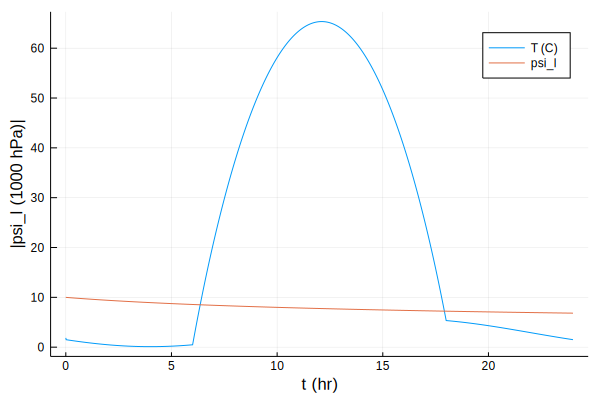

In [15]:
plot(t/3600, T_t-273.15*ones(size(T_t)),xlabel = "t (hr)",ylabel = "T (C)",label="T (C)")
plot!(t/3600,-psil_t/100000,xlabel = "t (hr)",ylabel = "|psi_l (1000 hPa)|",label="psi_l")

In [16]:
savefig(joinpath(output_dir, "T_psi_t.png"))

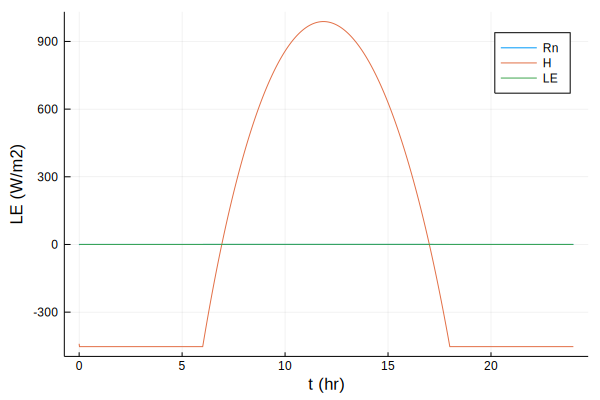

In [17]:
plot(t/3600,  Rn_t,xlabel = "t (hr)",ylabel = "Rn (W/m2)",label="Rn")
plot!(t/3600, H_t,xlabel  = "t (hr)",ylabel = "H (W/m2)" ,label="H")
plot!(t/3600, LE_t,xlabel = "t (hr)",ylabel = "LE (W/m2)",label="LE")